# Optical Character Recognition

This notebook is created to experiment with and develop image binarization algorithms to get the best optimal character recognition accuracy.

OCR used: Tesseract-OCR, Accuracy metrics: Word Error Rate

In [120]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np

pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

### Original Image

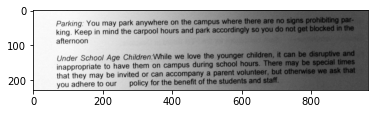

In [121]:
# Loading image in grayscale
img = cv2.imread('sample01.png', 0)
plt.imshow(img, cmap='gray')

In [122]:
original_output = pytesseract.image_to_string(img)
print(original_output)

Parking: You may park anywhere on the ce
king. Keep in mind the carpool hours and park
afternoon

Under School Age Children:While we love
inappropriate to have them on campus @ )
that they may be invited or can accompany :
you adhere to our _ policy for the benefit of

 



### Otsu Global Thresholding

In [123]:
def otsu_thresholding(img):

    histogram, bin_edges = np.histogram(img, bins=256)

    centers_bins = (bin_edges[:-1] + bin_edges[1:]) / 2.

    w1 = np.cumsum(histogram)
    w2 = np.cumsum(histogram[::-1])[::-1]

    u1 = np.cumsum(histogram * centers_bins) / w1
    u2 = (np.cumsum((histogram * centers_bins)[::-1]) / w2[::-1])[::-1]

    inter_var = w1[:-1] * w2[1:] * ((u1[:-1] - u2[1:]) ** 2)

    max_i = np.argmax(inter_var)

    th = round(centers_bins[:-1][max_i])

    return th

In [124]:
def binary_thresholding(img, threshold, method):
    
    new_img = []
    for rows in img:
        new_img.append(np.array(list(map(lambda cols: 0 if cols < threshold else 255, rows))))

    th_img = np.array(list(map(lambda x: np.array(x), new_img)))
    
    cv2.imwrite("otsu.png", th_img)
    
    return th_img

125


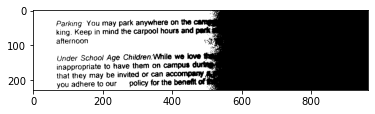

In [125]:
th = otsu_thresholding(img)
otsu = binary_thresholding(img, th, 'otsu')

print(th)
plt.imshow(otsu, cmap='gray')

In [126]:
otsu_output = pytesseract.image_to_string('otsu.png')
print(otsu_output)

Parking’ You may park anywhere on the cam
king. Keep in mind the carpool hours and pak,
afternoon

Under School Age Children:While we love
inappropriate to have them on campus ot <
that they may be invited or can accompany Agi
you adhere to our _ policy for the benefit of

 



In [127]:
import jiwer

def calculate_wer(output):
    
    ground_truth = 'parking you may park anywhere on the campus where there are no signs prohibiting parking keep in mind the carpool hours and park accordingly so you do not get blocked in the afternoon under school age childrenwhile we love the younger children it can be disruptive and inappropriate to have them on campus during school hours there may be special times that they may be invited or can accompany a parent volunteer but otherwise we ask that you adhere to our policy for the benefit of the students and staff'
    hypothesis = output

    transformation = jiwer.Compose([
        jiwer.ToLowerCase(),
        jiwer.ExpandCommonEnglishContractions(),
        jiwer.RemovePunctuation(),
        jiwer.RemoveWhiteSpace(replace_by_space=True),
        jiwer.RemoveMultipleSpaces(),
        jiwer.SentencesToListOfWords(word_delimiter=" "),
        jiwer.Strip(),
        jiwer.RemoveEmptyStrings()
    ])

    result = jiwer.wer(
        ground_truth, 
        hypothesis, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )

    word_error_rate = str(round(result*100, 2)) + '%'
    
    return word_error_rate

In [128]:
wer_original = calculate_wer(original_output)
print(wer_original)

50.0%


In [129]:
wer_otsu = calculate_wer(otsu_output)
print(wer_otsu)

52.22%


The accuracy produced by binary + otsu thresholding is worse than that of the original image

### Adaptive Mean Thresholding

In [226]:
def adaptive_mean(img, blockSize, C):
    
    rows, cols = img.shape
    idx = blockSize // 2
    thres_list = np.zeros((rows,cols))
    
    for x in range(rows):
        for y in range(cols):
            mean_list = []
            for z in range(blockSize):
                
                if x + z - idx < 0 or x + z - idx > rows - 1:
                    [mean_list.append(0) for i in range(blockSize)]
                else:
                    if y + z - idx < 0 or y + idx > cols - 1:
                        mean_list.append(0)
                    else:
                        [mean_list.append(img[x + z - idx][y + w - idx]) for w in range(blockSize)]
            
            thres_list[x][y] = sum(mean_list)//len(mean_list) - C
    
    return thres_list

In [227]:
def binary_thresholding_adapt(img, threshold, method):
    
    th_img = np.where(img<threshold, 0, 255)
    cv2.imwrite(method+".png", th_img)
    return th_img

(229, 965)
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


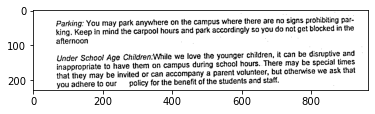

In [228]:
#blur = cv2.GaussianBlur(img,(7,7),0)
thres = adaptive_mean(img, 11, 7)
print(thres.shape)

adapt_mean = binary_thresholding_adapt(img, thres, 'adapt_mean')
print(adapt_mean)
plt.imshow(adapt_mean, cmap='gray')

In [229]:
adapt_mean_output = pytesseract.image_to_string('adapt_mean.png')
print(adapt_mean_output)

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under Schoo! Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours.. There may be special! times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our —_policy for the benefit of the students and staff.



In [230]:
wer_adapt_mean = calculate_wer(adapt_mean_output)
print(wer_adapt_mean)

4.44%


### Adaptive Gaussian Thresholding

In [231]:
def gaussian_function(kernel):
    
    sigma = 0.3*((kernel-1)*0.5 - 1) + 0.8
    gaussian_output = np.zeros((kernel, kernel), np.float32)
    x = kernel//2
    y = kernel//2
    
    for i in range(-x, x+1):
        for j in range(-y, y+1):
            a = 1 / (2 * np.pi * (sigma**2))
            b = np.exp(-(i**2 + j**2)/(2 * (sigma**2)))
            res = a * b
            gaussian_output[i+x, j+y] = res
    
    return gaussian_output.flatten().tolist()
    

def adaptive_gaussian(img, kernel, C):
    
    rows, cols = img.shape
    idx = kernel // 2
    thres_list = np.zeros((rows,cols))
    
    gaussian_filter = gaussian_function(kernel)
    
    for x in range(rows):
        for y in range(cols):
            points = []
            for z in range(kernel):
                
                if x + z - idx < 0 or x + z - idx > rows - 1:
                    [points.append(0) for i in range(kernel)]
                else:
                    if y + z - idx < 0 or y + idx > cols - 1:
                        points.append(0)
                    else:
                        [points.append(img[x + z - idx][y + w - idx]) for w in range(kernel)]
            
            weighted_list = [a * b for a, b in zip(points, gaussian_filter)]
            thres_list[x][y] = sum(weighted_list) - C
    
    return thres_list

(229, 965)
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


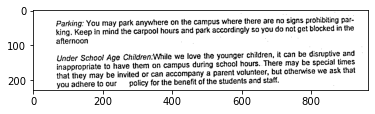

In [232]:
gaus = adaptive_gaussian(img, 11, 7)
print(gaus.shape)

adapt_gaussian = binary_thresholding_adapt(img, thres, 'adapt_gaussian')
print(adapt_gaussian)
plt.imshow(adapt_gaussian, cmap='gray')

In [233]:
adapt_gaus_output = pytesseract.image_to_string('adapt_gaussian.png')
print(adapt_gaus_output)

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under Schoo! Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours.. There may be special! times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our —_policy for the benefit of the students and staff.



In [234]:
wer_adapt_gaus = calculate_wer(adapt_gaus_output)
print(wer_adapt_gaus)

4.44%


### Automatic Skew Correction

In [251]:
from scipy.ndimage import interpolation as inter


def calculate_best_angle(image):
    
    delta = 1
    limit = 5
    
    var_scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        rotated_img = inter.rotate(image, angle, reshape=False, order=0)
        histogram = np.sum(rotated_img, axis=1)
        var_scores.append(np.sum((histogram[1:] - histogram[:-1]) ** 2))

    best_angle = angles[var_scores.index(max(var_scores))]
    
    return best_angle

def automatic_skew_correction(image):
    
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binarized_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 
    
    best_angle = calculate_best_angle(binarized_img)

    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated_img = cv2.warpAffine(image, M, (width, height), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)

    return rotated_img

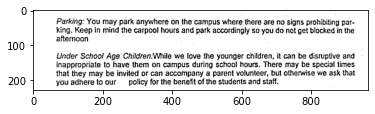

In [252]:
a_img = cv2.imread('adapt_mean.png')

rotated_img = automatic_skew_correction(a_img)
plt.imshow(rotated_img, cmap='gray')

In [253]:
adapt_mean_output_rotated = pytesseract.image_to_string(rotated_img)
print(adapt_mean_output_rotated)

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under School Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours.. There may be special! times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our _ policy for the benefit of the students and staff.



In [254]:
wer_adapt_mean_rotated = calculate_wer(adapt_mean_output_rotated)
print(wer_adapt_mean_rotated)

2.22%


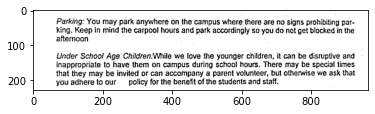

In [255]:
b_img = cv2.imread('adapt_gaussian.png')

rotated_img_2 = automatic_skew_correction(b_img)
plt.imshow(rotated_img_2, cmap='gray')

In [256]:
adapt_gauss_output_rotated = pytesseract.image_to_string(rotated_img_2)
print(adapt_gauss_output_rotated)

Parking: You may park anywhere on the campus where there are no signs prohibiting par-
king. Keep in mind the carpool hours and park accordingly so you do not get blocked in the
afternoon

Under School Age Children:While we love the younger children, it can be disruptive and
inappropriate to have them on campus during school hours.. There may be special! times
that they may be invited or can accompany a parent volunteer, but otherwise we ask that
you adhere to our _ policy for the benefit of the students and staff.



In [257]:
wer_adapt_gauss_rotated = calculate_wer(adapt_gauss_output_rotated)
print(wer_adapt_gauss_rotated)

2.22%


In [258]:
print("Printing all results:")
print("\n")
print("WER for original image:            " + wer_original)
print("WER for otsu:                      " + wer_otsu)
print("WER for adaptive mean:             " + wer_adapt_mean)
print("WER for adaptive gaussian:         " + wer_adapt_gaus)
print("WER for rotated adaptive mean:     " + wer_adapt_mean_rotated)
print("WER for rotated adaptive gaussian: " + wer_adapt_gauss_rotated)

Printing all results:


WER for original image:            50.0%
WER for otsu:                      52.22%
WER for adaptive mean:             4.44%
WER for adaptive gaussian:         4.44%
WER for rotated adaptive mean:     2.22%
WER for rotated adaptive gaussian: 2.22%


### Conclusion

The WER from the original image is drastically decreased from 50.0% to 2.22%, due to adaptive mean/gaussian thresholding, and automatic skew correction.